# Adversarial Variational Optimization: Poisson benchmark

This notebook shows the usage of `hypothesis` with `AVO` (Adversarial Variational Optimization) on the Poisson benchmark. In this inference setting, the goal is to obtain the model parameter $\mathbf{\theta}*$ that is responsible for generating $\mathbf{x}_o \sim p(\mathbf{x}|\mathbf{\theta})$.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import hypothesis

First, we need to be in the possesion of some $\mathbf{x}_o$:

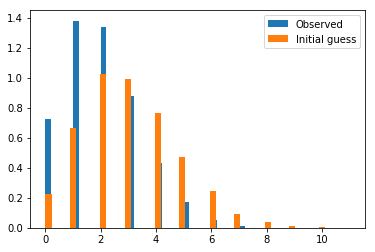

In [18]:
from hypothesis.benchmark.poisson import allocate_observations

truth = 1.95
observations = allocate_observations(truth)

# Show some observation, with some initial guess.
plt.hist(observations.numpy(), bins=50, label="Observed", density=True)
plt.hist(allocate_observations(3.).numpy(), bins=50, label="Initial guess", density=True)
plt.legend()
plt.show()

Clearly, our initial guess is completely wrong.

## AVO

### Discriminator

In [3]:
def allocate_discriminator():
    num_hidden = 50
    discriminator = torch.nn.Sequential(
        torch.nn.Linear(1, num_hidden),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(num_hidden, num_hidden),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(num_hidden, num_hidden),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(num_hidden, num_hidden),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(num_hidden, 1),
        torch.nn.Sigmoid()
    )
    
    return discriminator

### Simulator

In [4]:
from hypothesis.benchmark.poisson import PoissonSimulator as Simulator

simulator = Simulator()

### Proposal

In [5]:
from hypothesis.proposal import Normal as Proposal

proposal = Proposal()

### Inference

In [6]:
from hypothesis.inference import AdversarialVariationalOptimization

avo = AdversarialVariationalOptimization(simulator, allocate_discriminator())

In [7]:
proposal = avo.infer(observations, proposal=proposal, steps=100000)

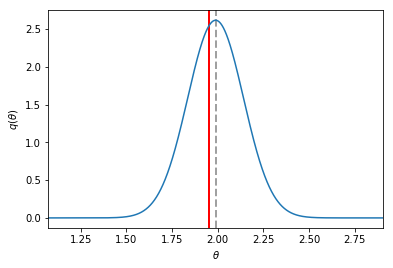

In [15]:
from hypothesis.visualization.avo import plot_proposal

plot_proposal(proposal, show_mean=True, truth=truth)

## Learning rate scheduling with hooks

To improve the procedure, we recommend to apply learning rate scheduling. This can be achieved using `hooks`.

In [19]:
from torch.optim.lr_scheduler import StepLR

stepper_discriminator = None
stepper_proposal = None

def initialize_learning_rate_scheduler(avo):
    global stepper_discriminator
    global stepper_proposal
    
    gamma = .1
    step_size = 5000
    stepper_discriminator = StepLR(avo.optimizer_discriminator, step_size=step_size, gamma=gamma)
    stepper_proposal = StepLR(avo.optimizer_proposal, step_size=step_size, gamma=gamma)
    
def learning_rate_scheduler_step(avo):
    global stepper_discriminator
    global stepper_proposal
    
    stepper_discriminator.step()
    stepper_proposal.step()
    
hypothesis.clear_hooks()
hypothesis.register_hook(hypothesis.hooks.pre_inference, initialize_learning_rate_scheduler)
hypothesis.register_hook(hypothesis.hooks.post_step, learning_rate_scheduler_step)

In [20]:
avo = AdversarialVariationalOptimization(simulator, allocate_discriminator())
scheduled_proposal = avo.infer(observations, proposal=proposal, steps=100000)

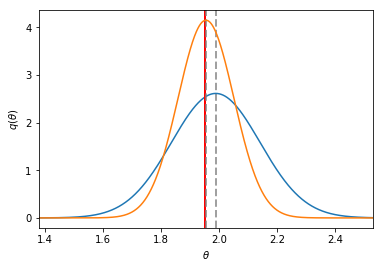

In [21]:
plot_proposal(proposal, show_mean=True, truth=truth)
plot_proposal(scheduled_proposal, show_mean=True, truth=truth)